## Training the model

Please run the following commands in the root folder


#### MNIST -> SVHN
- Few Shot target domain
  - `python train.py --dset_A_name MNIST --dset_B_name SVHN --lamb 1.0 --lr 0.0001 --num_epochs 1000 --batch_sz 700  --num_dest_per_class 10` 


- All target domain
  - `python train.py --dset_A_name MNIST --dset_B_name SVHN --lamb 1.0 --lr 0.0001 --num_epochs 1000 --batch_sz 700 --dset_B_all`

#### Fashion_MNIST -> Fashion_WILD
- Few shot target domain
  - `python train.py --dset_A_name Fashion_MNIST --dset_B_name Fashion_WILD --batchnorm_track --num_dest_per_class 10`
- All target domain
  - `python train.py --dset_A_name Fashion_MNIST --dset_B_name Fashion_WILD --batchnorm_track --dset_B_all`



## Visualizing embeddings: MNIST -> SVHN

### Load trained model

In [11]:
import torch
import numpy as np
from models.net5g_two_head import ClusterNet5gTwoHead
import argparse


class Config:
    batchnorm_track = False
    num_sub_heads = 5
    output_k_A = 50
    output_k_B = 10
    input_sz = 32
    rand_crop_sz = 20
    include_rgb = False
    batch_sz = 700
    num_classes = 10
    
config = Config()

config.output_k = config.output_k_B

if config.include_rgb:
    config.in_channels = 5
else:
    config.in_channels = 2

model = ClusterNet5gTwoHead(config)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load("results/iic-adapt-mnist2svhn.pt"))
model = model.cuda()


avg_pool_sz 3
semisup: False


### Initialize Datasets

In [12]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from utils.transforms import custom_greyscale_to_tensor
from utils.data import get_latent_and_targets

# Load src dataset
src_tf = transforms.Compose([
    transforms.CenterCrop(config.rand_crop_sz),
    transforms.Resize(config.input_sz),
    custom_greyscale_to_tensor(config.include_rgb),
])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=src_tf)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=src_tf)
src_dataset = ConcatDataset([mnist_train, mnist_test])


# Load dest dataset
dest_tf = transforms.Compose([
    transforms.CenterCrop(config.rand_crop_sz),
    transforms.Resize(config.input_sz),
    custom_greyscale_to_tensor(config.include_rgb),
])
dest_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=dest_tf)

src_loader = DataLoader(src_dataset, batch_size=config.batch_sz, shuffle=False)
dest_loader = DataLoader(dest_dataset, batch_size=config.batch_sz, shuffle=False)



Using downloaded and verified file: ./data/test_32x32.mat


### Get best subhead by getting best accuracy

In [14]:
from utils.data import get_preds_and_targets, get_preds_actual_class
from utils.eval_metrics import hungarian_match, accuracy

src_preds, src_targets = get_preds_and_targets(config, model, src_loader)
dest_preds, dest_targets = get_preds_and_targets(config, model, dest_loader)

src_preds = src_preds.cuda()
src_targets = src_targets.cuda()

dest_preds = dest_preds.cuda()
dest_targets = dest_targets.cuda()


def get_stats(preds, targets):
    matches = []
    accs = []
    for i in range(config.num_sub_heads):
        match = hungarian_match(preds[i], targets, num_classes=config.num_classes)
        matches.append(match)
        actual_preds = get_preds_actual_class(preds[i], match, config)
        acc = accuracy(actual_preds, targets, config.num_classes)
        accs.append(acc)

    best_subhead = np.argmax(accs)
    worst_subhead = np.argmin(accs)
    
    return {
        "best": accs[best_subhead],
        "avg": np.mean(accs),
        "std": np.std(accs),
        "worst": accs[worst_subhead],
        "best_subhead": best_subhead,
        "worst_subhead": worst_subhead,
        "best_train_sub_head": matches[best_subhead],
        "accs": accs,
    }

def print_stats(stats):
    for key in stats:
        print("{} : {}".format(key, stats[key]))
    print()

src_stats = get_stats(src_preds, src_targets)
dest_stats = get_stats(dest_preds, dest_targets)

print("Src Stats")
print_stats(src_stats)

print("Dest Stats")
print_stats(dest_stats)


Src Stats
best : 0.4168142857142857
avg : 0.4162
std : 0.0004950365890414515
worst : 0.4156142857142857
best_subhead : 1
worst_subhead : 4
best_train_sub_head : [(0, 9), (1, 3), (2, 8), (3, 7), (4, 2), (5, 4), (6, 6), (7, 0), (8, 5), (9, 1)]
accs : [0.4158, 0.4168142857142857, 0.4160142857142857, 0.4167571428571429, 0.4156142857142857]

Dest Stats
best : 0.32394744929317765
avg : 0.32277197295636145
std : 0.0008319503427401196
worst : 0.32145052243392747
best_subhead : 4
worst_subhead : 0
best_train_sub_head : [(0, 5), (1, 4), (2, 2), (3, 8), (4, 0), (5, 6), (6, 3), (7, 1), (8, 7), (9, 9)]
accs : [0.32145052243392747, 0.32241087891825443, 0.32321757836508913, 0.3228334357713583, 0.32394744929317765]



/home/bong/.virtualenvs/ee298f/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


### Get latent vectors for all samples from source and destination datasets

In [15]:
src_latents, src_targets = get_latent_and_targets(config, model, src_loader, src_dataset)
dest_latents, dest_targets = get_latent_and_targets(config, model, dest_loader, dest_dataset)

src_latents = src_latents[src_stats["best_subhead"]].cpu().numpy()
src_targets = src_targets.cpu().numpy()

dest_latents = dest_latents[dest_stats["best_subhead"]].cpu().numpy()
dest_targets = dest_targets.cpu().numpy()

print("Src Latents Size: {}".format(src_latents.shape))
print("Src Targets Size: {}".format(src_targets.shape))

print("Dest Latents Size: {}".format(dest_latents.shape))
print("Dest Targets Size: {}".format(dest_targets.shape))

Src Latents Size: (70000, 10)
Src Targets Size: (70000,)
Dest Latents Size: (26032, 10)
Dest Targets Size: (26032,)


### Reduce latent vectors dimension with tSNE

In [16]:
from sklearn.manifold import TSNE

src_latents_reduced = TSNE(n_components=2, verbose=True, n_jobs=4).fit_transform(src_latents)
dest_latents_reduced = TSNE(n_components=2, verbose=True, n_jobs=4).fit_transform(dest_latents)

print("Src Latents Reduced Size: {}".format(src_latents_reduced.shape))
print("Dest Latents Reduced Size: {}".format(dest_latents_reduced.shape))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 70000 samples in 0.295s...
[t-SNE] Computed neighbors for 70000 samples in 4.822s...
[t-SNE] Computed conditional probabilities for sample 1000 / 70000
[t-SNE] Computed conditional probabilities for sample 2000 / 70000
[t-SNE] Computed conditional probabilities for sample 3000 / 70000
[t-SNE] Computed conditional probabilities for sample 4000 / 70000
[t-SNE] Computed conditional probabilities for sample 5000 / 70000
[t-SNE] Computed conditional probabilities for sample 6000 / 70000
[t-SNE] Computed conditional probabilities for sample 7000 / 70000
[t-SNE] Computed conditional probabilities for sample 8000 / 70000
[t-SNE] Computed conditional probabilities for sample 9000 / 70000
[t-SNE] Computed conditional probabilities for sample 10000 / 70000
[t-SNE] Computed conditional probabilities for sample 11000 / 70000
[t-SNE] Computed conditional probabilities for sample 12000 / 70000
[t-SNE] Computed conditional probabilities for sam

### Visualize embeddings of source dataset

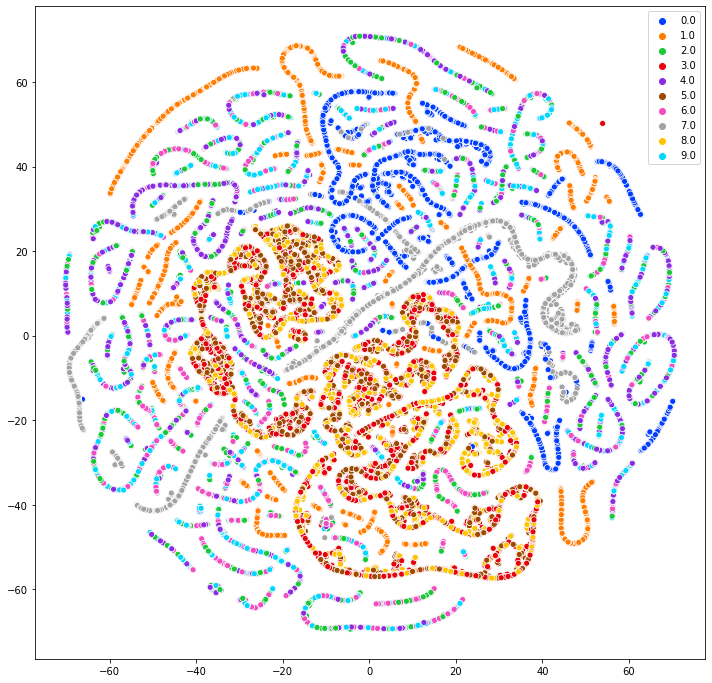

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("bright", 10)
plt.figure(figsize=(12, 12))
sns.scatterplot(src_latents_reduced[:, 0], src_latents_reduced[:, 1], hue=src_targets, legend='full', palette=palette)

### Visualize embeddings of dest dataset

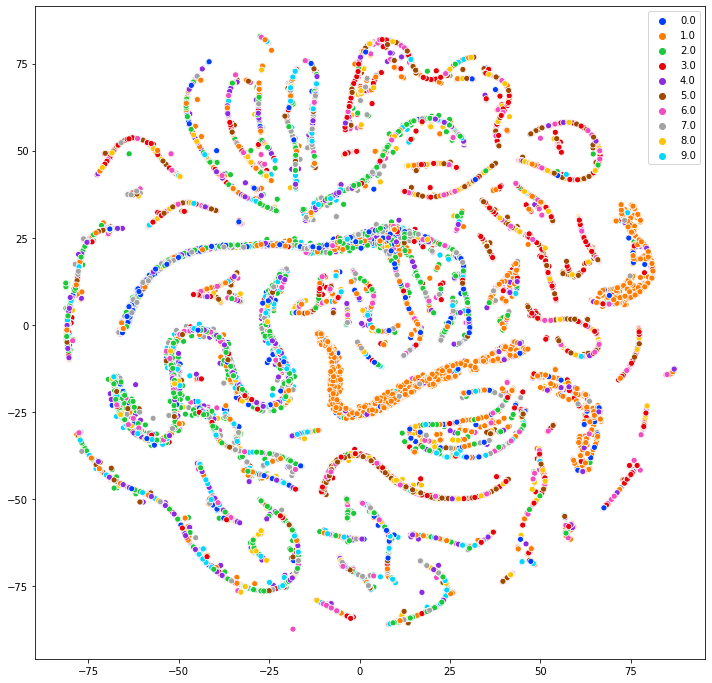

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("bright", 10)
plt.figure(figsize=(12, 12))
sns.scatterplot(dest_latents_reduced[:, 0], dest_latents_reduced[:, 1], hue=dest_targets, legend='full', palette=palette)

## Visualizing Embeddings: Fashion MNIST -> Fashion Wild

### Load trained model

In [28]:
import torch
import numpy as np
from models.net5g_two_head import ClusterNet5gTwoHead
import argparse


class Config:
    batchnorm_track = False
    num_sub_heads = 5
    output_k_A = 50
    output_k_B = 10
    input_sz = 32
    rand_crop_sz = 20
    include_rgb = False
    batch_sz = 700
    num_classes = 10
    
config = Config()

config.output_k = config.output_k_B

if config.include_rgb:
    config.in_channels = 5
else:
    config.in_channels = 2

model = ClusterNet5gTwoHead(config)
model = torch.nn.DataParallel(model)
state_dict = torch.load("results/iic-adapt-fmnist2fwild.pt")
model.load_state_dict(state_dict, strict=False)
model = model.cuda()


avg_pool_sz 3
semisup: False


### Initialize dataset

In [31]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from utils.transforms import custom_greyscale_to_tensor
from utils.data import get_latent_and_targets

# Load src dataset
src_tf = transforms.Compose([
    transforms.Resize((config.input_sz, config.input_sz)),
    custom_greyscale_to_tensor(config.include_rgb),
])

fmnist_train = datasets.FashionMNIST('./data', train=True, download=True, transform=src_tf)
fmnist_test = datasets.FashionMNIST('./data', train=False, download=True, transform=src_tf)
src_dataset = ConcatDataset([fmnist_train, fmnist_test])


# Load dest dataset
dest_tf = transforms.Compose([
    transforms.Resize((config.input_sz, config.input_sz)),
    custom_greyscale_to_tensor(config.include_rgb),
])
dest_dataset = datasets.ImageFolder('./data/FASHION_WILD/test', transform=dest_tf)

src_loader = DataLoader(src_dataset, batch_size=config.batch_sz, shuffle=False)
dest_loader = DataLoader(dest_dataset, batch_size=config.batch_sz, shuffle=False)



### Get best subhead by getting best accuracy

In [32]:
from utils.data import get_preds_and_targets, get_preds_actual_class
from utils.eval_metrics import hungarian_match, accuracy

src_preds, src_targets = get_preds_and_targets(config, model, src_loader)
dest_preds, dest_targets = get_preds_and_targets(config, model, dest_loader)

src_preds = src_preds.cuda()
src_targets = src_targets.cuda()

dest_preds = dest_preds.cuda()
dest_targets = dest_targets.cuda()


def get_stats(preds, targets):
    matches = []
    accs = []
    for i in range(config.num_sub_heads):
        match = hungarian_match(preds[i], targets, num_classes=config.num_classes)
        matches.append(match)
        actual_preds = get_preds_actual_class(preds[i], match, config)
        acc = accuracy(actual_preds, targets, config.num_classes)
        accs.append(acc)

    best_subhead = np.argmax(accs)
    worst_subhead = np.argmin(accs)
    
    return {
        "best": accs[best_subhead],
        "avg": np.mean(accs),
        "std": np.std(accs),
        "worst": accs[worst_subhead],
        "best_subhead": best_subhead,
        "worst_subhead": worst_subhead,
        "best_train_sub_head": matches[best_subhead],
        "accs": accs,
    }

def print_stats(stats):
    for key in stats:
        print("{} : {}".format(key, stats[key]))
    print()

src_stats = get_stats(src_preds, src_targets)
dest_stats = get_stats(dest_preds, dest_targets)

print("Src Stats")
print_stats(src_stats)

print("Dest Stats")
print_stats(dest_stats)


Src Stats
best : 0.2245
avg : 0.20196857142857141
std : 0.015516499184377112
worst : 0.18262857142857142
best_subhead : 0
worst_subhead : 1
best_train_sub_head : [(0, 9), (1, 4), (2, 7), (3, 8), (4, 2), (5, 0), (6, 5), (7, 1), (8, 3), (9, 6)]
accs : [0.2245, 0.18262857142857142, 0.21547142857142856, 0.19408571428571428, 0.19315714285714286]

Dest Stats
best : 0.24
avg : 0.21600000000000003
std : 0.01496662954709576
worst : 0.2
best_subhead : 3
worst_subhead : 0
best_train_sub_head : [(0, 1), (1, 9), (2, 8), (3, 6), (4, 2), (5, 4), (6, 0), (7, 5), (8, 3), (9, 7)]
accs : [0.2, 0.22, 0.22, 0.24, 0.2]



/home/bong/.virtualenvs/ee298f/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


### Get latent vectors

In [33]:
src_latents, src_targets = get_latent_and_targets(config, model, src_loader, src_dataset)
dest_latents, dest_targets = get_latent_and_targets(config, model, dest_loader, dest_dataset)

src_latents = src_latents[src_stats["best_subhead"]].cpu().numpy()
src_targets = src_targets.cpu().numpy()

dest_latents = dest_latents[dest_stats["best_subhead"]].cpu().numpy()
dest_targets = dest_targets.cpu().numpy()

print("Src Latents Size: {}".format(src_latents.shape))
print("Src Targets Size: {}".format(src_targets.shape))

print("Dest Latents Size: {}".format(dest_latents.shape))
print("Dest Targets Size: {}".format(dest_targets.shape))

Src Latents Size: (70000, 10)
Src Targets Size: (70000,)
Dest Latents Size: (50, 10)
Dest Targets Size: (50,)


### Reduce latent vectors dimension with tSNE

In [34]:
from sklearn.manifold import TSNE

src_latents_reduced = TSNE(n_components=2, verbose=True, n_jobs=4).fit_transform(src_latents)
dest_latents_reduced = TSNE(n_components=2, verbose=True, n_jobs=4).fit_transform(dest_latents)

print("Src Latents Reduced Size: {}".format(src_latents_reduced.shape))
print("Dest Latents Reduced Size: {}".format(dest_latents_reduced.shape))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 70000 samples in 0.140s...
[t-SNE] Computed neighbors for 70000 samples in 2.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 70000
[t-SNE] Computed conditional probabilities for sample 2000 / 70000
[t-SNE] Computed conditional probabilities for sample 3000 / 70000
[t-SNE] Computed conditional probabilities for sample 4000 / 70000
[t-SNE] Computed conditional probabilities for sample 5000 / 70000
[t-SNE] Computed conditional probabilities for sample 6000 / 70000
[t-SNE] Computed conditional probabilities for sample 7000 / 70000
[t-SNE] Computed conditional probabilities for sample 8000 / 70000
[t-SNE] Computed conditional probabilities for sample 9000 / 70000
[t-SNE] Computed conditional probabilities for sample 10000 / 70000
[t-SNE] Computed conditional probabilities for sample 11000 / 70000
[t-SNE] Computed conditional probabilities for sample 12000 / 70000
[t-SNE] Computed conditional probabilities for sam

### Visualize embeddings of source dataset

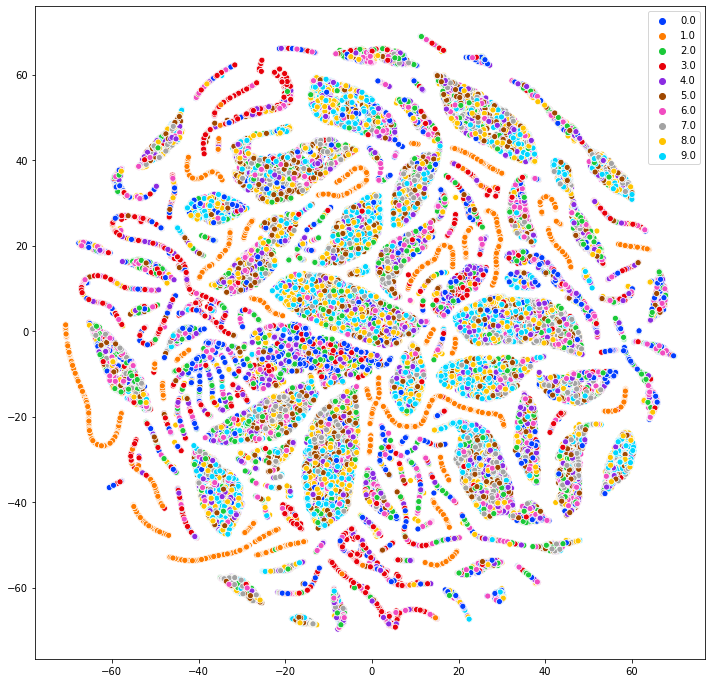

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("bright", 10)
plt.figure(figsize=(12, 12))
sns.scatterplot(src_latents_reduced[:, 0], src_latents_reduced[:, 1], hue=src_targets, legend='full', palette=palette)

### Visualize embeddings of destination dataset

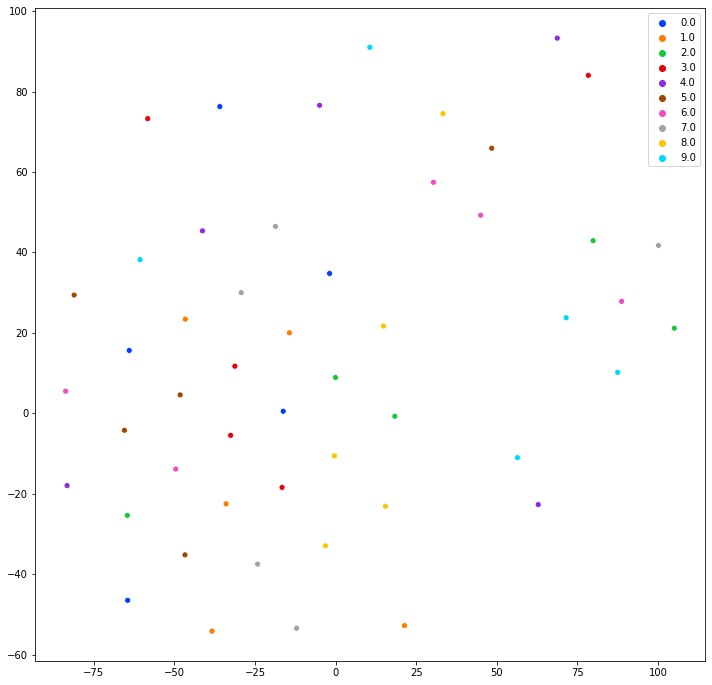

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("bright", 10)
plt.figure(figsize=(12, 12))
sns.scatterplot(dest_latents_reduced[:, 0], dest_latents_reduced[:, 1], hue=dest_targets, legend='full', palette=palette)